In [18]:
import cv2
import os
import shutil
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import tensorflow as tf

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data')


## Yolo files config version 1 - no categories removed. 
Note: I optimized Version 2 below further. You could skip to version 2 instead

In [13]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data')

def create_yoloconfig_structure(raw_data_path):
  import pandas as pd
  import os

  os.chdir(raw_data_path)

  directory = 'malaria'
  yolo_directory = "vivax_yolo_config"
  images_directory =  "images"
  train_directory = "train"
  val_directory = "val"
  test_directory = "test"
  labels_directory = "labels"

  rootpath = os.path.join(raw_data_path, directory)
  yolopath = os.path.join(rootpath, yolo_directory)

  yolo_images_path =  os.path.join(yolopath, images_directory)
  yolo_train_images_path = os.path.join(yolo_images_path, train_directory)
  yolo_val_images_path = os.path.join(yolo_images_path, val_directory)
    
  yolo_test_images_path = os.path.join(yolo_images_path, test_directory)
  yolo_labels_path = os.path.join(yolopath, labels_directory)
  yolo_train_labels_path = os.path.join(yolo_labels_path, train_directory)
  yolo_val_labels_path = os.path.join(yolo_labels_path, val_directory)
  yolo_test_labels_path = os.path.join(yolo_labels_path, test_directory)

  if not os.path.exists(yolo_labels_path):
      os.makedirs(yolo_labels_path)

  if not os.path.exists(yolo_train_images_path):
      os.makedirs(yolo_train_images_path)

  if not os.path.exists(yolo_val_images_path):
      os.makedirs(yolo_val_images_path)
      
  if not os.path.exists(yolo_test_images_path):
      os.makedirs(yolo_test_images_path)

  if not os.path.exists(yolo_train_labels_path):
      os.makedirs(yolo_train_labels_path)

  if not os.path.exists(yolo_val_labels_path):
      os.makedirs(yolo_val_labels_path)
    
  if not os.path.exists(yolo_test_labels_path):
      os.makedirs(yolo_test_labels_path)

  # Creating the yaml file
  doc = open(os.path.join(yolopath, 'vivax.yaml'), 'w')

  doc.write(f'path: {yolopath}')
  doc.write('\n')
  doc.write(f'train: {os.path.relpath(yolo_train_images_path, yolopath)}')
  doc.write('\n')
  doc.write(f'val: {os.path.relpath(yolo_val_images_path, yolopath)}')
  doc.write('\n')
  doc.write(f'test: {os.path.relpath(yolo_test_images_path, yolopath)}')
  doc.write('\n')
  doc.write('names:')
  doc.write('\n')
  names_lines = ['  0: red blood cell', '  1: leukocyte', '  2: gametocyte', '  3: ring', '  4: trophozoite', '  5: schizont', '  6: difficult']
  for line in names_lines:
    doc.write(line)
    doc.write('\n')

  doc.close()

  return yolopath, yolo_labels_path, yolo_train_images_path, yolo_val_images_path, yolo_test_images_path, yolo_train_labels_path, yolo_val_labels_path, yolo_test_labels_path, doc

In [11]:
def yolo_json_to_df(jsonfiledir, jsonfilename):
  import pandas as pd
  import numpy as np
    
  # Extracting txt labels from json file
  jsonfiledir = jsonfiledir + '/'
  readlocation = jsonfiledir + jsonfilename
  json_df = pd.read_json(readlocation)
  json_df['path'] = json_df['image'].map(lambda x: jsonfiledir + x['pathname'][1:])
  json_df['shape'] = json_df['image'].map(lambda x: x['shape'])

  json_object_df = pd.DataFrame([dict(image=c_row['path'], shape=c_row['shape'], **c_item) for _, c_row in json_df.iterrows() for c_item in c_row['objects']])

  json_object_df['image_width'] = json_object_df['shape'].map(lambda x: x['c'])
  json_object_df['image_height'] = json_object_df['shape'].map(lambda x: x['r'])
  json_object_df['image_name'] = json_object_df['image'].map(lambda x: x.split('/', x.count("/"))[-1])
  json_object_df['class_label'] = json_object_df['category'].map({'red blood cell': 0, 'leukocyte': 1, 'gametocyte': 2, 'ring': 3, 'trophozoite': 4, 'schizont': 5, 'difficult': 6})

  json_object_df['center_x'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['c'] + (x['maximum']['c'] - x['minimum']['c'])/2 )
  json_object_df['center_y'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['r'] + (x['maximum']['r'] - x['minimum']['r'])/2 )
  json_object_df['width'] = json_object_df['bounding_box'].map(lambda x: (x['maximum']['c'] - x['minimum']['c']))
  json_object_df['height'] = json_object_df['bounding_box'].map(lambda x: (x['maximum']['r'] - x['minimum']['r']))


  # Normalizing the values
  json_object_df['center_x'] = json_object_df['center_x'] / json_object_df['image_width']
  json_object_df['center_y'] = json_object_df['center_y'] / json_object_df['image_height']
  json_object_df['width'] = json_object_df['width'] / json_object_df['image_width']
  json_object_df['height'] = json_object_df['height'] / json_object_df['image_height']
    

  # Randomly select some of the images for validation
  if 'train' in jsonfilename:
        
        # Asking for data balancing
        balance = ''
        
        print(json_object_df['category'].value_counts())
        
        while balance != 'Y' and balance != 'N':
            balance = input('\n The statistics above present the categories proportion. Do you want to balance the training dataset (Y/N)?') 
        
        #If the user opts for data balancing, the most represented class(es) proportion will be reduced to the same proportion as the less represented class.
            if balance == 'Y':
                json_train_df = pd.DataFrame(columns = json_object_df.columns)
                for cat in json_object_df['category'].unique():
                    temp_df = json_object_df[json_object_df['category']==cat].sample(n = json_object_df['category'].value_counts()[-1], replace=False)
                    json_train_df = pd.concat([json_train_df, temp_df])
                
                json_val_df = json_object_df.drop(index=json_train_df.index).sample(n=round(0.3*json_train_df.shape[0]), replace=False)
                
            else:
                json_val_df = json_object_df.sample(frac=0.3, replace=False)
                json_train_df = json_object_df.copy().drop(index = json_val_df.index)
        
        json_test_df = pd.DataFrame({'A' : []})

  elif 'test' in jsonfilename:
      json_val_df = pd.DataFrame({'A' : []})
      json_train_df = pd.DataFrame({'A' : []})
      json_test_df = json_object_df.copy()
      
    
  return json_train_df, json_val_df, json_test_df

In [14]:
def yolo_files_config(imagesdir, jsonfiledir, jsonfilename, raw_data_path):
  # Organizing images (train vs. test or val) and exporting them with the bounding boxes files into the corresponding yolo config files
  json_train_df, json_val_df, json_test_df = yolo_json_to_df(jsonfiledir, jsonfilename)
  yolopath, yolo_labels_path, yolo_train_images_path, yolo_val_images_path, yolo_test_images_path, yolo_train_labels_path, yolo_val_labels_path, yolo_test_labels_path, doc = create_yoloconfig_structure(raw_data_path)

  import shutil
  if 'train' in jsonfilename:
    
    for pic in json_train_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_train_images_path)
        filename_save = yolo_train_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_train_df[json_train_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')

    for pic in json_val_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_val_images_path)
        filename_save = yolo_val_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_val_df[json_val_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')
  
  elif 'test' in jsonfilename:   
        
    for pic in json_test_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_test_images_path)
        filename_save = yolo_test_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_test_df[json_test_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')


  print(f"All yolo files and folders have been created in the following location: {yolopath}. \n Your yaml file is: {doc} ")

## Yolo files config version 2 - gives the user options for removing some cells categories from the data and creating a "more balanced" dataset (albeit reduced) if needed (e.g. the class "difficult" in this case)
Note: in some cases, you may need to manually update the classes in the yaml file after the lines of code below have created it

In [3]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data')

def create_yoloconfig_structure(raw_data_path):
  import pandas as pd
  import os

  os.chdir(raw_data_path)

  directory = 'malaria'
  yolo_directory = "vivax_yolo_config"
  images_directory =  "images"
  train_directory = "train"
  val_directory = "val"
  test_directory = "test"
  labels_directory = "labels"

  rootpath = os.path.join(raw_data_path, directory)
  yolopath = os.path.join(rootpath, yolo_directory)

  yolo_images_path =  os.path.join(yolopath, images_directory)
  yolo_train_images_path = os.path.join(yolo_images_path, train_directory)
  yolo_val_images_path = os.path.join(yolo_images_path, val_directory)
    
  yolo_test_images_path = os.path.join(yolo_images_path, test_directory)
  yolo_labels_path = os.path.join(yolopath, labels_directory)
  yolo_train_labels_path = os.path.join(yolo_labels_path, train_directory)
  yolo_val_labels_path = os.path.join(yolo_labels_path, val_directory)
  yolo_test_labels_path = os.path.join(yolo_labels_path, test_directory)

  if not os.path.exists(yolo_labels_path):
      os.makedirs(yolo_labels_path)

  if not os.path.exists(yolo_train_images_path):
      os.makedirs(yolo_train_images_path)

  if not os.path.exists(yolo_val_images_path):
      os.makedirs(yolo_val_images_path)
      
  if not os.path.exists(yolo_test_images_path):
      os.makedirs(yolo_test_images_path)

  if not os.path.exists(yolo_train_labels_path):
      os.makedirs(yolo_train_labels_path)

  if not os.path.exists(yolo_val_labels_path):
      os.makedirs(yolo_val_labels_path)
    
  if not os.path.exists(yolo_test_labels_path):
      os.makedirs(yolo_test_labels_path)

  # Creating the yaml file
  doc = open(os.path.join(yolopath, 'vivax.yaml'), 'w')

  doc.write(f'path: {yolopath}')
  doc.write('\n')
  doc.write(f'train: {os.path.relpath(yolo_train_images_path, yolopath)}')
  doc.write('\n')
  doc.write(f'val: {os.path.relpath(yolo_val_images_path, yolopath)}')
  doc.write('\n')
  doc.write(f'test: {os.path.relpath(yolo_test_images_path, yolopath)}')
  doc.write('\n')
  doc.write('names:')
  doc.write('\n')
  names_lines = ['  0: red blood cell', '  1: leukocyte', '  2: gametocyte', '  3: ring', '  4: trophozoite', '  5: schizont', '  6: difficult']
  for line in names_lines:
    doc.write(line)
    doc.write('\n')

  doc.close()

  return yolopath, yolo_labels_path, yolo_train_images_path, yolo_val_images_path, yolo_test_images_path, yolo_train_labels_path, yolo_val_labels_path, yolo_test_labels_path, doc

In [4]:
def removecat(df):
    remove = ' '
    while remove != 'Y' and remove != 'N':
        remove = input('\n The statistics above present the categories proportion. Would you want to completely remove some categories? (Y/N)')
        
    if remove == 'Y':
        removelist=[]
        num_remove = input('\n How many categories do you intend to remove?')
        while len(removelist) < int(num_remove):
            removecat= input('\n Please provide one of the categories you want to remove').strip(" []' ")
            removelist.append(removecat)
        
        for j in removelist:
            if j not in list(df['category'].unique()):
                removelist.remove(j)
        
        remainingcat = np.setdiff1d(list(df['category'].unique()), removelist)
    
    else:
        remainingcat = df['category'].unique()
        removelist = []

    return removelist, remainingcat

In [5]:
def reassign_cat_labels(df):
    result_dict = {}
    cat_list = list(df['category'].unique())

    for j in cat_list:
        result_dict[j]=cat_list.index(j)
        
    return result_dict

In [6]:
def yolo_json_to_df(jsonfiledir, jsonfilename):
  import pandas as pd
  import numpy as np
    
  # Extracting txt labels from json file
  jsonfiledir = jsonfiledir + '/'
  readlocation = jsonfiledir + jsonfilename
  json_df = pd.read_json(readlocation)
  json_df['path'] = json_df['image'].map(lambda x: jsonfiledir + x['pathname'][1:])
  json_df['shape'] = json_df['image'].map(lambda x: x['shape'])

  json_object_df = pd.DataFrame([dict(image=c_row['path'], shape=c_row['shape'], **c_item) for _, c_row in json_df.iterrows() for c_item in c_row['objects']])

  json_object_df['image_width'] = json_object_df['shape'].map(lambda x: x['c'])
  json_object_df['image_height'] = json_object_df['shape'].map(lambda x: x['r'])
  json_object_df['image_name'] = json_object_df['image'].map(lambda x: x.split('/', x.count("/"))[-1])
  json_object_df['class_label'] = json_object_df['category'].map({'red blood cell': 0, 'leukocyte': 1, 'gametocyte': 2, 'ring': 3, 'trophozoite': 4, 'schizont': 5, 'difficult': 6})

  json_object_df['center_x'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['c'] + (x['maximum']['c'] - x['minimum']['c'])/2 )
  json_object_df['center_y'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['r'] + (x['maximum']['r'] - x['minimum']['r'])/2 )
  json_object_df['width'] = json_object_df['bounding_box'].map(lambda x: (x['maximum']['c'] - x['minimum']['c']))
  json_object_df['height'] = json_object_df['bounding_box'].map(lambda x: (x['maximum']['r'] - x['minimum']['r']))


  # Normalizing the values
  json_object_df['center_x'] = json_object_df['center_x'] / json_object_df['image_width']
  json_object_df['center_y'] = json_object_df['center_y'] / json_object_df['image_height']
  json_object_df['width'] = json_object_df['width'] / json_object_df['image_width']
  json_object_df['height'] = json_object_df['height'] / json_object_df['image_height']
    

  # Randomly select some of the images for validation
  if 'train' in jsonfilename:
        
        # Asking for data balancing
        
        
        print(json_object_df['category'].value_counts())

        remainingcat = removecat(json_object_df)[1]
      
        balance = ''
        while balance != 'Y' and balance != 'N':
            balance = input('\n Would you want to balance the training dataset (Y/N)?') 
        
        #If the user opts for data balancing, the most represented class(es) proportion will be reduced to the same proportion as the less represented class.
            if balance == 'Y':
                json_train_df = pd.DataFrame(columns = json_object_df.columns)
                for cat in remainingcat:
                    temp_df = json_object_df[json_object_df['category']==cat].sample(n = json_object_df['category'].value_counts()[-1], replace=False)
                    json_train_df = pd.concat([json_train_df, temp_df])
                
                json_val_df = json_object_df.drop(index=json_train_df.index).sample(n=round(0.3*json_train_df.shape[0]), replace=False)
                
            else:
                json_val_df = json_object_df.sample(frac=0.3, replace=False)
                json_train_df = json_object_df.copy().drop(index = json_val_df.index)
        
        json_test_df = pd.DataFrame({'A' : []})
        json_train_df['class_label'] = json_train_df['category'].map(reassign_cat_labels(json_train_df))
        json_val_df['class_label'] = json_val_df['category'].map(reassign_cat_labels(json_val_df))
        print(f'New classes assignment: {reassign_cat_labels(json_train_df)}')

  elif 'test' in jsonfilename:
      print(json_object_df['category'].value_counts())
      json_val_df = pd.DataFrame({'A' : []})
      json_train_df = pd.DataFrame({'A' : []})

      remainingcat = removecat(json_object_df)[1]
      json_test_df = pd.DataFrame(columns = json_object_df.columns)
      
      for cat in remainingcat:    
          temp_df = json_object_df[json_object_df['category']==cat]
          json_test_df = pd.concat([json_test_df, temp_df])
              
      json_test_df['class_label'] = json_test_df['category'].map(reassign_cat_labels(json_test_df))
      print(f'New classes assignment: {reassign_cat_labels(json_test_df)}')


  return json_train_df, json_val_df, json_test_df

In [7]:
def yolo_files_config(imagesdir, jsonfiledir, jsonfilename, raw_data_path):
  # Organizing images (train vs. test or val) and exporting them with the bounding boxes files into the corresponding yolo config files
  json_train_df, json_val_df, json_test_df = yolo_json_to_df(jsonfiledir, jsonfilename)
  yolopath, yolo_labels_path, yolo_train_images_path, yolo_val_images_path, yolo_test_images_path, yolo_train_labels_path, yolo_val_labels_path, yolo_test_labels_path, doc = create_yoloconfig_structure(raw_data_path)

  import shutil
  if 'train' in jsonfilename:
    
    for pic in json_train_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_train_images_path)
        filename_save = yolo_train_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_train_df[json_train_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')

    for pic in json_val_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_val_images_path)
        filename_save = yolo_val_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_val_df[json_val_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')
  
  elif 'test' in jsonfilename:   
        
    for pic in json_test_df['image_name'].unique():
        shutil.copy2(os.path.join(imagesdir, pic), yolo_test_images_path)
        filename_save = yolo_test_labels_path + '/' + pic[:len(pic) - 3] + 'txt'
        json_test_df[json_test_df['image_name'] == pic].iloc[:, 7:].to_csv(filename_save, header=None, index=None, sep=' ')


  print(f"All yolo files and folders have been created in the following location: {yolopath}. \n Your yaml file is: {doc} ")

## Examples Applying functions for Yolo config (with version 2 functions above)
Note: remember to adjust the input data folders according to your system configuration, before running the lines below

In [ ]:
imdir = '/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/malaria/images'
malaria_dir = '/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data/malaria'
jsonfilename = 'training.json'
raw_data_path='/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification/raw_data'

yolo_files_config(imdir, malaria_dir, jsonfilename, raw_data_path)

In [ ]:
jsonfilename = 'test.json'

yolo_files_config(imdir, malaria_dir, jsonfilename, raw_data_path)


## Images visualization with their respective bounding box(es) extracted from json

In [11]:
def load_image(img_path):#, label):
    img_file = tf.io.read_file(img_path)
    image = tf.image.decode_image(img_file)
    # image = tf.image.resize_with_pad(image, 250, 240)
    # image = image / 255.
    return image#, label

In [33]:
def display_img_with_box(img_path, label_path):

    label_df = pd.read_csv(label_path, names=['category', 'center_x', 'center_y', 'width', 'height'], sep=' ')

    # Display the image
    ax = plt.gca()
    ax.imshow(load_image(img_path))
    

    for i in range(label_df.shape[0]):

        label_i = label_df['category'][i]
        anchor_x_i = (label_df['center_x'][i] - (label_df['width'][i]/2))*load_image(img_path).shape[1]
        anchor_y_i = (label_df['center_y'][i] - (label_df['height'][i]/2))*load_image(img_path).shape[0] 
        rect_width_i = label_df['width'][i]*load_image(img_path).shape[1]
        rect_height_i = label_df['height'][i]*load_image(img_path).shape[0]
    
        # print(anchor_x_i, anchor_y_i) 

    
        # Create a Rectangle patch
        rect_i = patches.Rectangle((anchor_x_i, anchor_y_i), rect_width_i, rect_height_i, linewidth=1, edgecolor='r', facecolor='none')
    
        # Add the patch to the Axes
        ax.add_patch(rect_i)
        ax.annotate(label_i, (anchor_x_i - 10, anchor_y_i - 10), color='red', weight='bold', fontsize=12, ha='center', va='center')


## Examples Applying functions for Data visualization functions above
Note: remember to adjust the input data folders according to your system configuration, before running the lines below

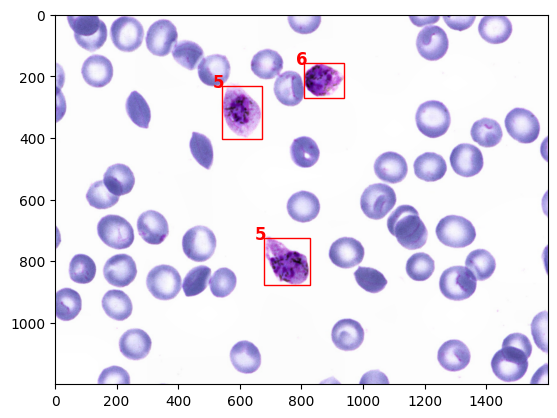

In [39]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification')
img_path = 'raw_data/malaria/vivax_yolo_config_all_formodel/images/train/0d2aba33-6920-4001-bd54-59fe0bf9f50e.png'

label_path = 'raw_data/malaria/vivax_yolo_config_all_formodel/labels/train/0d2aba33-6920-4001-bd54-59fe0bf9f50e.txt'

display_img_with_box(img_path, label_path)

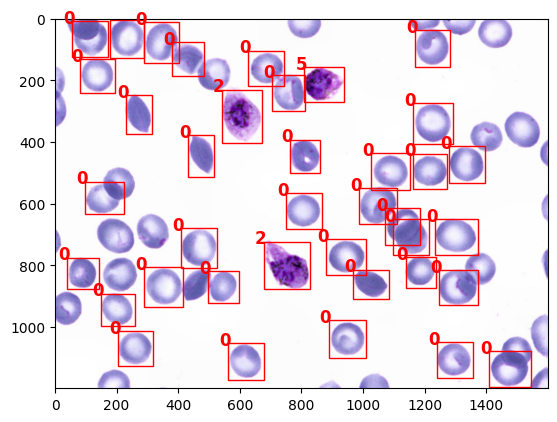

In [36]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification')
img_path = 'raw_data/malaria/vivax_yolo_config_imbalanced/images/train/0d2aba33-6920-4001-bd54-59fe0bf9f50e.png'

label_path = 'raw_data/malaria/vivax_yolo_config_imbalanced/labels/train/0d2aba33-6920-4001-bd54-59fe0bf9f50e.txt'

display_img_with_box(img_path, label_path)

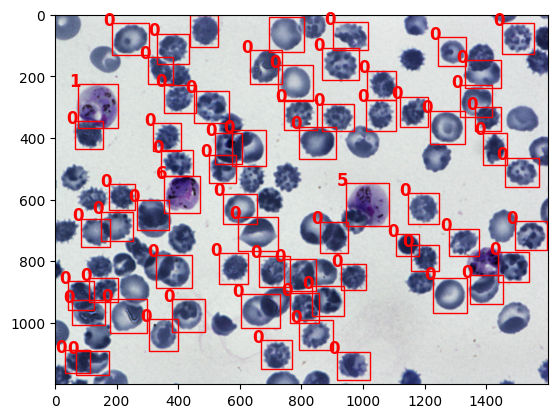

In [40]:
os.chdir('/home/muriel/code/XiaoniuZhangSlb/Malaria_Classification')
img_path = 'raw_data/malaria/vivax_yolo_config_imbalanced/images/train/0d3c2521-da55-4df5-bf06-56b3bd4fb2fc.png'

label_path = 'raw_data/malaria/vivax_yolo_config_imbalanced/labels/train/0d3c2521-da55-4df5-bf06-56b3bd4fb2fc.txt'

display_img_with_box(img_path, label_path)




## Installing Ultralytics and updating Pytorch version to overcome errors encountered during Yolo model runs

In [9]:
# ! pip install ultralytics

# from ultralytics import YOLO
# from IPython import display
# display.clear_output()
# !yolo checks

In [10]:
# ls /usr/local |grep cuda
# pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
# !echo $LD_LIBRARY_PATH ##checking for /usr/local/cuda/lib64

## Cells Cropping and extraction 
Used after the Yolo model results to further identify the infection stages

In [149]:
def json_to_df(jsonfiledir, jsonfilename):
  import pandas as pd
  import numpy as np
    
  # Extracting txt labels from json file
  jsonfiledir = jsonfiledir + '/'
  readlocation = jsonfiledir + jsonfilename
  json_df = pd.read_json(readlocation)
  json_df['path'] = json_df['image'].map(lambda x: jsonfiledir + x['pathname'][1:])
  json_df['shape'] = json_df['image'].map(lambda x: x['shape'])

  json_object_df = pd.DataFrame([dict(image=c_row['path'], shape=c_row['shape'], **c_item) for _, c_row in json_df.iterrows() for c_item in c_row['objects']])

  json_object_df['image_width'] = json_object_df['shape'].map(lambda x: x['c'])
  json_object_df['image_height'] = json_object_df['shape'].map(lambda x: x['r'])
  json_object_df['image_name'] = json_object_df['image'].map(lambda x: x.split('/', x.count("/"))[-1])
  json_object_df['class_label'] = json_object_df['category'].map({'red blood cell': 0, 'leukocyte': 1, 'gametocyte': 2, 'ring': 3, 'trophozoite': 4, 'schizont': 5, 'difficult': 6})

  json_object_df['box_x_min'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['c'])
  json_object_df['box_x_max'] = json_object_df['bounding_box'].map(lambda x: x['maximum']['c'])
  json_object_df['box_y_min'] = json_object_df['bounding_box'].map(lambda x: x['minimum']['r'])
  json_object_df['box_y_max'] = json_object_df['bounding_box'].map(lambda x: x['maximum']['r'])

  json_object_df['cropped_image_name'] = json_object_df['image_name'].str[:-4] + '_'+ json_object_df.index.astype('str') + json_object_df['image_name'].str[-4:]
    
  return json_object_df

In [167]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def crop_images(df, directory):
    
    newfolder = os.path.join(directory, get_df_name(df))
    if not os.path.isdir(newfolder):
        os.makedirs(newfolder)
    
    for i, row in df.iterrows():
        im = cv2.imread(row['image'])
    
        ymin = row['box_y_min'] 
        ymax = row['box_y_max'] 
        xmin = row['box_x_min'] 
        xmax = row['box_x_max']
        
        cropped_im = im[ymin:ymax, xmin:xmax]
    
        location = os.path.join(newfolder, row['cropped_image_name'])
        cv2.imwrite(location, cropped_im)

    
    df['cropped_image_path'] = df['cropped_image_name'].map(lambda x: os.path.join(newfolder, x))
    temp_df = df[['cropped_image_path', 'cropped_image_name', 'class_label', 'category']]
    temp_df.to_csv(directory + '_' + get_df_name(df) + '.csv')
    
    return newfolder

## Balancing & structuring cropped images & dataset files

In [168]:
def balance_remove_cat(csvfilepath, removecategorieslist=[]):
    cropped_images_df = pd.read_csv(csvfilepath, index=0)
    balanced_cropped_df = pd.DataFrame(columns = cropped_images_df.columns)
    cropped_removedcategories_df=pd.DataFrame(columns = cropped_images_df.columns)
    
    if len(removecategorieslist)>0:
        cat_list = np.setdiff1d(cropped_images_df['category'].unique(), removecategorieslist)
        cropped_removedcategories_df = cropped_images_df[cropped_images_df['category'].isin(removecategorieslist)]
    
    for cat in cat_list:
        temp_df = cropped_images_df[cropped_images_df['category']==cat].sample(n = cropped_images_df['category'].value_counts()[-1], replace=False)
        balanced_cropped_df = pd.concat([balanced_cropped_df, temp_df])

    return balanced_cropped_df, cropped_removedcategories_df
    

In [171]:
def image_restructure(df, df_type='train'):
    df = df.reset_index()
    dir = os.path.split(os.path.split(df.loc[0][1])[0])[0]
    dir = os.path.join(dir, 'balanced_cropped_images')
    
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    if df_type=='train':
        dir_suffix = 'train'
    elif df_type=='test':
        dir_suffix = 'test'
    else:
        dir_suffix = df_type

    df['new_image_path'] = df['cropped_image_path'].map(lambda x: path_update(x, dir))
    
    df_dir = os.path.join(dir, dir_suffix)
    
    if not os.path.exists(df_dir):
        os.makedirs(df_dir)
        for label in df['category'].unique():
            class_folder = os.path.join(df_dir, str(label))
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)
                
    for i in range(df.shape[0]):
        path = df.iloc[i]['cropped_image_path']
        pic = path.split('/', path.count("/"))[-1]
        piclabel = df.iloc[i]['category']
        folder=os.path.join(df_dir, str(piclabel))
        shutil.copy2(path, folder)

    df.to_csv(os.path.join(os.path.split(df_dir)[0], 'balanced_cropped_'+df_type+'images_table.csv'))
    
    print(f'Complete. Check results in {dir}') 
    
    return df
    

## Models

#### Functions applicable to all models

In [175]:
def compilation(model):
    loss_function = tf.keras.losses.CategoricalCrossentropy()
    metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()]
    # metrics = ['accuracy', 'precision', 'recall', 'auc', 'f1score']
    
    model = model.compile(loss = loss_function, optimizer = 'adam', metrics = metrics)
    return model

In [176]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0, 5)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['categorical_accuracy'], label='train categorical accuracy'  + exp_name)
    ax2.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy'  + exp_name)
    ax2.set_ylim(0, 1.)
    ax2.set_title('Categorical Accuracy')
    ax2.legend()
    return (ax1, ax2)

#### Simple model

In [173]:
def simple_conv_model():
    model = Sequential()

    model.add(layers.Rescaling(1/255, input_shape = (250, 240, 3)))
    model.add(layers.Conv2D(7, 3, activation = 'relu', padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(5, 2, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))   
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(3, 2, activation = 'relu'))
    # model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(6, activation = 'softmax'))
                
    return model

#### VGG16

In [172]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def set_nontrainable_layers(model):
    model.trainable = False  
    return model
    
def updated_vgg16_model():

    input = layers.Input(shape = (250, 240, 3))
    x = preprocess_input(input)
    
    vgg16model = VGG16(weights="imagenet", include_top=False)
    base_model = set_nontrainable_layers(vgg16model)
    
    x = base_model(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(100, activation='relu')(x)
    output = layers.Dense(6, activation='softmax')(x)
    
    
    # model = Sequential([base_model, flatten_layer, dense_layer, prediction_layer])
    model = tf.keras.Model(inputs = input, outputs = output)
    
    metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()]

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

    return model